## Customer Churn Analysis

# The story Behind The Data
A bank is concerned that more and more customers are leaving its credit card services. They would really appreciate if someone could analyze it for them, in order to understand the main reasons for leaving the services, and to come up with recommendations for how the bank can mitigate that. Eventually, the bank would like to proactively implement these recommendations in order to keep their customers happy.

**A full ERD can be found [here](https://dbdiagram.io/d/638cdd8abae3ed7c45449eed)**

# Data Description
In this task, few datasets are provided:

1. **`BankChurners.csv`**   - this file contains basic information about each client (10 columns). The columns are:
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account;
    - `Attrition Flag` - Internal event (customer activity) variable - if the client had churned (attrited) or not (existing).
    - `Dependent Count` - Demographic variable - Number of dependents
    - `Card_Category` - Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
    - `Months_on_book` - Period of relationship with bank
    - `Months_Inactive_12_mon` - No. of months inactive in the last 12 months
    - `Contacts_Count_12_mon` - No. of Contacts in the last 12 months
    - `Credit_Limit` - Credit Limit on the Credit Card
    - `Avg_Open_To_Buy` - Open to Buy Credit Line (Average of last 12 months)
    - `Avg_Utilization_Ratio` - Average Card Utilization Ratio
    
    
2. **`basic_client_info.csv`** - this file contains some basic client info per each client
(6 columns) -
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account
    - `Customer Age` - Demographic variable - Customer's Age in Years
    - `Gender` - Demographic variable - M=Male, F=Female
    - `Education_Level` - Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.`
    - `Marital_Status` - Demographic variable - Married, Single, Divorced, Unknown
    - `Income_Category` - Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)
    
3. **`enriched_churn_data.csv`** - this file contains some enriched data about each client (7 columns) -
    - `CLIENTNUM` - Client number. Unique identifier for the customer holding the account
    - `Total_Relationship_Count` - Total no. of products held by the customer
    - `Total_Revolving_Bal` - Total Revolving Balance on the Credit Card
    - `Total_Amt_Chng_Q4_Q1` - Change in Transaction Amount (Q4 over Q1)
    - `Total_Trans_Amt` - Total Transaction Amount (Last 12 months)
    - `Total_Trans_Ct` - Total Transaction Count (Last 12 months)
    - `Total_Ct_Chng_Q4_Q1` - Change in Transaction Count (Q4 over Q1)

In [1]:
# import necessary libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

### Data wrangling

In [2]:
# import from csv
data0 = pd.read_csv('bankchurners.csv')
data1 = pd.read_csv('enriched_churn_data.csv')
data2 = pd.read_csv('basic_client_info.csv')

In [3]:
# merge all tables
data01 = pd.merge(data0, data1, on='clientnum')
data = pd.merge(data01, data2, on='clientnum')
df = pd.DataFrame(data=data)

In [4]:
pd.set_option('max_colwidth', 10)
pd.set_option('display.max_columns', 21)
df.sample(10)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category
3756,708972783,Attrit...,4,Blue,37,2,3,1745.0,1745.0,0.000,3,0,0.657,2297,0.630,44,48,F,College,Married,Less t...
4135,713480583,Existi...,3,Blue,36,2,2,4668.0,4668.0,0.000,5,0,0.890,1612,1.474,47,46,F,High S...,Married,Unknown
9377,736145283,Existi...,2,Blue,24,1,4,1669.0,1669.0,0.000,6,0,0.698,3591,0.788,59,43,M,College,Married,$80K -...
1022,720254883,Existi...,0,Blue,46,1,3,5877.0,4180.0,0.289,6,1697,1.058,2494,0.706,58,65,F,High S...,Married,$40K -...
8090,788805108,Existi...,3,Blue,30,3,3,18123.0,16348.0,0.098,5,1775,0.593,4259,0.860,80,47,M,High S...,Single,$60K -...
7397,708195633,Existi...,2,Silver,32,2,3,34516.0,33334.0,0.034,5,1182,0.613,2440,0.543,54,40,M,High S...,Unknown,$80K -...
6833,713569158,Attrit...,3,Blue,34,3,2,1654.0,180.0,0.891,1,1474,0.586,2086,0.621,47,43,F,High S...,Single,$40K -...
3496,708462258,Existi...,1,Blue,38,1,2,5189.0,4018.0,0.226,1,1171,0.732,16563,0.741,94,51,F,High S...,Married,Less t...
5017,714084483,Attrit...,3,Blue,36,2,3,3855.0,3644.0,0.055,4,211,0.485,1724,0.308,34,49,F,Uneduc...,Single,Unknown
9306,718654533,Existi...,1,Silver,24,2,2,12956.0,12956.0,0.000,5,0,1.053,2492,0.931,56,33,F,High S...,Single,Less t...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   card_category             10127 non-null  object 
 4   months_on_book            10127 non-null  int64  
 5   months_inactive_12_mon    10127 non-null  int64  
 6   contacts_count_12_mon     10127 non-null  int64  
 7   credit_limit              10127 non-null  float64
 8   avg_open_to_buy           10127 non-null  float64
 9   avg_utilization_ratio     10127 non-null  float64
 10  total_relationship_count  10127 non-null  int64  
 11  total_revolving_bal       10127 non-null  int64  
 12  total_amt_chng_q4_q1      10127 non-null  float64
 13  total_trans_amt           10127 non-null  int64  
 14  total_

### Data Cleaning

In [6]:
#make a copy
df_clean = df.copy()

In [7]:
#check duplicates
df_clean.duplicated().sum()

0

In [8]:
#check nulls
df_clean.attrition_flag.isna().sum()

0

In [9]:
## Pre-processing

In [10]:
cat_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object']
cat_cols               

['attrition_flag',
 'card_category',
 'gender',
 'education_level',
 'marital_status',
 'income_category']

In [11]:
num_cols = [n for n in df_clean.columns if df_clean[n].dtype != 'object']
num_cols  

['clientnum',
 'dependent_count',
 'months_on_book',
 'months_inactive_12_mon',
 'contacts_count_12_mon',
 'credit_limit',
 'avg_open_to_buy',
 'avg_utilization_ratio',
 'total_relationship_count',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_ct_chng_q4_q1',
 'total_trans_ct',
 'customer_age']

In [12]:
df_clean[num_cols].describe()

,clientnum,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age
count,1.0127...,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....,10127....
mean,7.3917...,2.346203,35.928409,2.341167,2.455317,8631.9...,7469.1...,0.274894,3.812580,1162.8...,0.759941,4404.0...,0.712222,64.858695,46.325960
std,3.6903...,1.298908,7.986416,1.010622,1.106225,9088.7...,9090.6...,0.275691,1.554408,814.98...,0.219207,3397.1...,0.238086,23.472570,8.016814
min,7.0808...,0.000000,13.000000,0.000000,0.000000,1438.3...,3.000000,0.000000,1.000000,0.000000,0.000000,510.00...,0.000000,10.000000,26.000000
25%,7.1303...,1.000000,31.000000,2.000000,2.000000,2555.0...,1324.5...,0.023000,3.000000,359.00...,0.631000,2155.5...,0.582000,45.000000,41.000000
50%,7.1792...,2.000000,36.000000,2.000000,2.000000,4549.0...,3474.0...,0.176000,4.000000,1276.0...,0.736000,3899.0...,0.702000,67.000000,46.000000
75%,7.7314...,3.000000,40.000000,3.000000,3.000000,11067....,9859.0...,0.503000,5.000000,1784.0...,0.859000,4741.0...,0.818000,81.000000,52.000000
max,8.2834...,5.000000,56.000000,6.000000,6.000000,34516....,34516....,0.999000,6.000000,2517.0...,3.397000,18484....,3.714000,139.00...,73.000000


In [13]:
df_clean.attrition_flag.value_counts()  #below the anual churning rate?

Existing Customer    8500
Attrited Customer    1627
Name: attrition_flag, dtype: int64

In [14]:
# Define a dictionary mapping the categories to binary values
dict_ch = {
    'Existing Customer': 0,
    'Attrited Customer': 1,
}

# Use the map() method to replace the values in the 'attrition_flag' column
df_clean['churned'] = df_clean['attrition_flag'].map(dict_ch)

In [15]:
# Drop the original 'attrition_flag' column
df_clean.drop('attrition_flag', axis=1, inplace=True)

In [16]:
df_clean

,clientnum,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category,churned
0,806160108,1,Blue,56,2,3,3193.0,676.0,0.788,2,2517,1.831,1336,1.143,30,61,M,High S...,Married,$40K -...,0
1,804424383,1,Blue,56,3,2,10215.0,9205.0,0.099,3,1010,0.843,1904,1.000,40,63,M,Unknown,Married,$60K -...,0
2,708300483,0,Blue,56,4,3,7882.0,7277.0,0.077,5,605,1.052,704,0.143,16,66,F,Doctorate,Married,Unknown,1
3,808284783,1,Blue,56,0,0,1438.3,1438.3,0.000,6,0,0.813,1951,1.095,44,62,F,Unknown,Married,Less t...,0
4,712720158,1,Blue,56,2,3,13860.0,12208.0,0.119,5,1652,1.255,1910,1.909,32,68,M,Graduate,Married,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,714082308,3,Blue,13,1,3,8656.0,8656.0,0.000,2,0,0.893,8056,0.935,89,39,M,High S...,Single,$80K -...,1
10123,710751033,1,Blue,13,1,3,4829.0,4829.0,0.000,1,0,0.836,8286,0.857,65,31,F,Graduate,Single,Less t...,1
10124,780118158,0,Blue,13,2,4,3585.0,1165.0,0.675,2,2420,0.812,15656,0.746,124,27,M,Graduate,Single,Less t...,0
10125,779082633,2,Blue,13,2,3,4107.0,3128.0,0.238,3,979,0.647,14596,0.733,104,30,M,Uneduc...,Single,$60K -...,0


In [17]:
# Calculate the percentage of churned customers
num_churned = df_clean[df_clean["churned"] == 1].shape[0]
num_total = df_clean.shape[0]
percent_churned = (num_churned / num_total) * 100

# Format the result as a percentage
print("Percentage of churned customers: {:.2f}%".format(percent_churned))

Percentage of churned customers: 16.07%


#### Observations

The annual churn rate for credit cards can vary greatly depending on the type of card and the target demographic. On average, it is common to see an annual churn rate of around 20% for credit cards. However, some high-end, premium credit cards may have a lower churn rate, while cards targeted towards subprime borrowers may have a higher churn rate.

It's important to note that a lower churn rate is typically seen as a positive sign for a credit card issuer, as it indicates that customers are satisfied with the card and less likely to switch to a different one. On the other hand, a higher churn rate can indicate that customers are not satisfied with the card or are switching to a different one with more attractive terms.

A preliminary overview of the dataset shows that around 83.93% of customers are active, while 16.07% have churned.

In [18]:
#Convert 'attrition_flag'to boolean dtype
dict_g = {
    'F': ['Female'],
    'M': [' Male'],
}
df_clean['gender'] = df_clean['gender']
df_clean.replace({"gender": dict_g}, inplace=True)

In [19]:
df.describe(include='object')

,attrition_flag,card_category,gender,education_level,marital_status,income_category
count,10127,10127,10127,10127,10127,10127
unique,2,4,2,7,4,6
top,Existi...,Blue,F,Graduate,Married,Less t...
freq,8500,9436,5358,3128,4687,3561


In [20]:
df_clean.describe().loc[['min', 'max', 'mean']].round(2)

,clientnum,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,churned
min,7.0808...,0.00,13.00,0.00,0.00,1438.30,3.00,0.00,1.00,0.00,0.00,510.00,0.00,10.00,26.00,0.00
max,8.2834...,5.00,56.00,6.00,6.00,34516.00,34516.00,1.00,6.00,2517.00,3.40,18484.00,3.71,139.00,73.00,1.00
mean,7.3917...,2.35,35.93,2.34,2.46,8631.95,7469.14,0.27,3.81,1162.81,0.76,4404.09,0.71,64.86,46.33,0.16


In [21]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   dependent_count           10127 non-null  int64  
 2   card_category             10127 non-null  object 
 3   months_on_book            10127 non-null  int64  
 4   months_inactive_12_mon    10127 non-null  int64  
 5   contacts_count_12_mon     10127 non-null  int64  
 6   credit_limit              10127 non-null  float64
 7   avg_open_to_buy           10127 non-null  float64
 8   avg_utilization_ratio     10127 non-null  float64
 9   total_relationship_count  10127 non-null  int64  
 10  total_revolving_bal       10127 non-null  int64  
 11  total_amt_chng_q4_q1      10127 non-null  float64
 12  total_trans_amt           10127 non-null  int64  
 13  total_ct_chng_q4_q1       10127 non-null  float64
 14  total_

In [22]:
# filter for churned
df_churned = df_clean[df_clean['churned'] == 1]

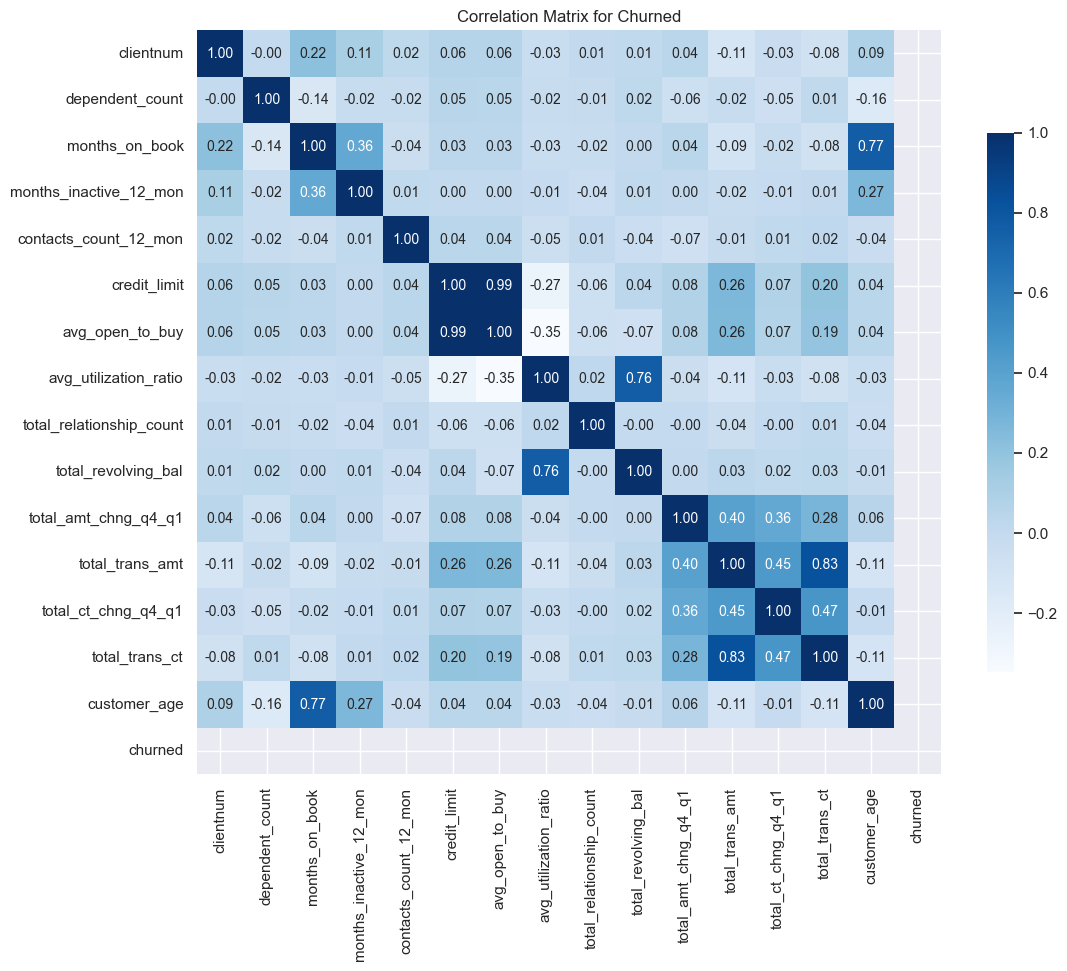

In [23]:
# Generate a correlation matrix
corr_matrix = df_churned.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.7},
            xticklabels=1,
            yticklabels=1)
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Churned')
plt.show()

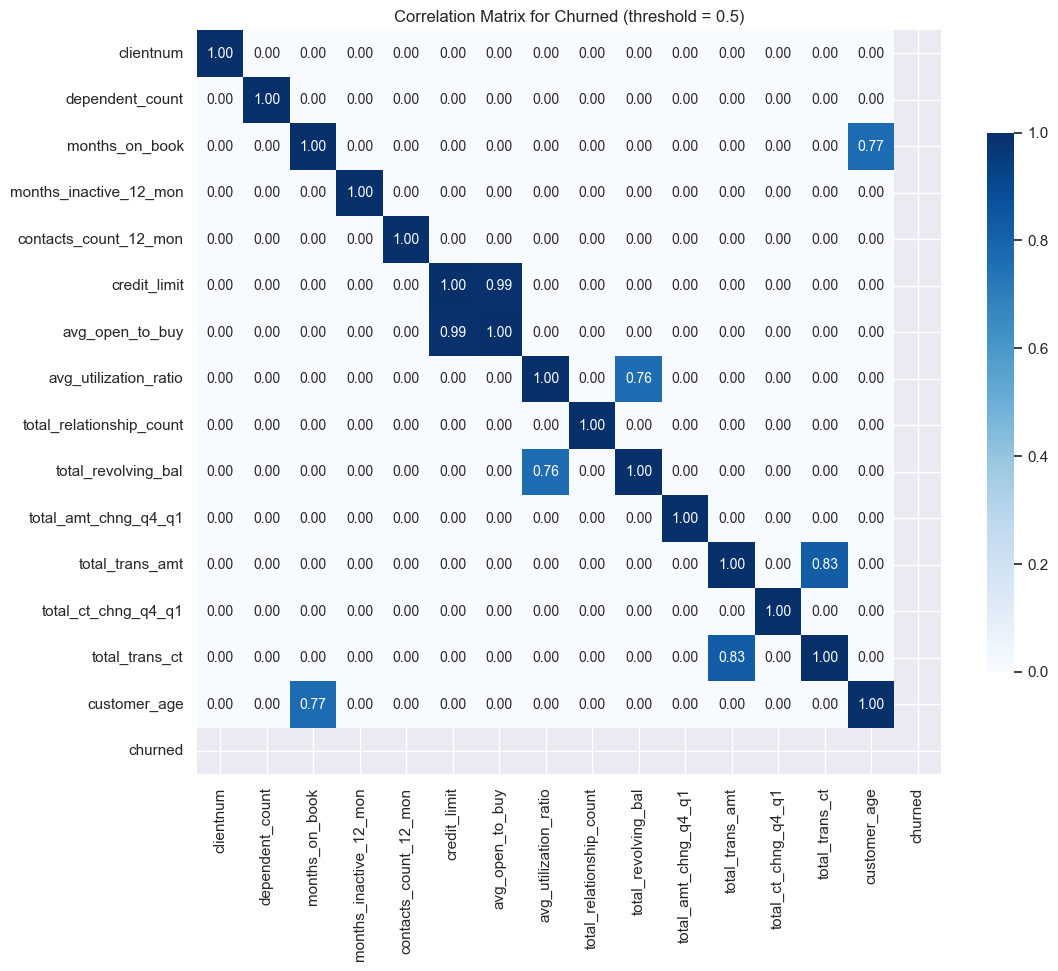

In [24]:
# Generate a correlation matrix
corr_matrix = df_churned.corr(numeric_only=True)

# Set a threshold for displaying correlations
thresh = 0.5
corr_matrix[abs(corr_matrix) < thresh] = 0

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.7},
            xticklabels=1,
            yticklabels=1)
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Churned (threshold = {})'.format(thresh))
plt.show()

In [25]:
##second XGB TEST


In [26]:
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X,
                           columns=[
                               'card_category', 'gender', 'education_level',
                               'marital_status', 'income_category'
                           ])
X = X_encoded
y = df_clean['churned']
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final round boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

[22:30:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:30:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:30:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:30:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0   0.387699         0.000992        0.389799        0.000

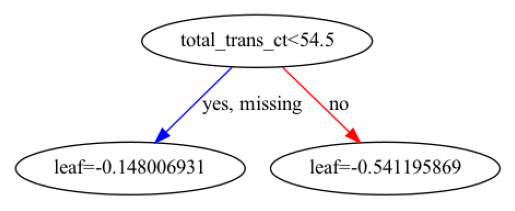

In [27]:
# Create the DMatrix: housing_dmatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic", "max_depth":1}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()



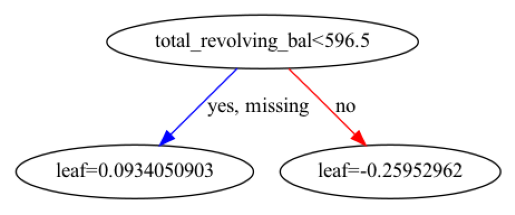

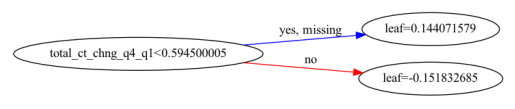

In [28]:
# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=-1,rankdir='LR')
plt.show()

In [31]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
cat_cols_upt = [c for c in df_clean.columns if df_clean[c].dtype == 'object']
  

# Split the data into X and y
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']

# One-hot encode the categorical variables in X

enc = OneHotEncoder(sparse=False)
X_encoded = pd.DataFrame(enc.fit_transform(X[cat_cols_upt]), columns=enc.get_feature_names(cat_cols_upt))
X_encoded = pd.concat([X.drop(cat_cols_upt, axis=1), X_encoded], axis=1)

# Create the DMatrix: housing_dmatrix
dmatrix = xgb.DMatrix(data=X_encoded, label=y)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()


/Users/filipafontes/opt/anaconda3/envs/py3_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

/Users/filipafontes/opt/anaconda3/envs/py3_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


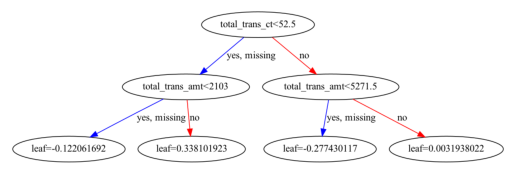

In [35]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder



# Identify categorical columns
cat_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object']

# Split the data into X and y
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']

# One-hot encode the categorical variables in X
enc = OneHotEncoder(sparse=False)
X_encoded = enc.fit_transform(X[cat_cols])
feature_names = []
for i, col in enumerate(cat_cols):
    for val in sorted(X[col].unique()):
        feature_names.append(f'{col}_{val}')
X_encoded = pd.DataFrame(X_encoded, columns=feature_names)
X_encoded = pd.concat([X.drop(cat_cols, axis=1), X_encoded], axis=1)

# Create the DMatrix: housing_dmatrix
dmatrix = xgb.DMatrix(data=X_encoded, label=y)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=7)
plt.show()


In [ ]:
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X,
                           columns=[
                               'card_category', 'gender', 'education_level',
                               'marital_status', 'income_category'
                           ])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:', confusion_mat)

# Visualize the model's feature importances
importances = pd.Series(xgb_model.feature_importances_,
                        index=X_encoded.columns)
importances_nonzero = importances[importances != 0].sort_values(ascending=True)
importances_nonzero.plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances (XGBoost)')
plt.xlabel('F score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Retrain the XGBoost model with the most important features
important_features = importances_nonzero.tail(10).index.tolist()
X_important = X_encoded[important_features]
X_train_important, X_test_important, y_train, y_test = train_test_split(
    X_important, y, test_size=0.2, random_state=42)
xgb_model_important = xgb.XGBClassifier()
xgb_model_important.fit(X_train_important, y_train)

# Evaluate the model on the testing set
y_pred = xgb_model_important.predict(X_test_important)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion matrix:', confusion_mat)

In [ ]:
# Create an XGBoost classifier with default hyperparameters
clf = xgb.XGBClassifier()

# Perform 5-fold cross-validation on the data
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')

# Print the average F1 score across all folds
print('Average F1 score:', scores.mean())

In [ ]:
# initialize the logistic regression model
lr_model = LogisticRegression()

# train the model on the training data
lr_model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = lr_model.predict(X_test)

# evaluate the model's performance
print(classification_report(y_test, y_pred, zero_division=1))

 - In the context of XGBoost, the F-score refers to the feature importance score calculated for each feature. The F-score is a measure of the total reduction in the impurity of the model when splitting on a particular feature. It is used to rank the importance of features in the model and can be used to identify the most relevant features for prediction. Features with higher F-scores are considered more important to the model.

### Economics

In [ ]:
# Plot distribution of total transaction count by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='total_trans_ct',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Transaction Count by Attrition Flag')
plt.xlabel('Total Transaction Count')
plt.ylabel('Density')
plt.show()

In [ ]:
churned_trans_by_gender_age = df_clean[df_clean['churned'] == 1].groupby(
    ['gender'])['total_trans_ct'].describe()
pd.set_option('max_colwidth', 20)
pd.set_option('display.max_columns', 10)
churned_trans_by_gender_age

In [ ]:
# Plot distribution of total revolving balance by attrition flag
plt.figure(figsize=(10, 6), dpi=250)
sns.kdeplot(data=df_clean,
            x='total_revolving_bal',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Revolving Balance by Attrition Flag')
plt.xlabel('Total Revolving Balance')
plt.ylabel('Density')
plt.show()

In [ ]:
churned_bal_by_gender_age = df_clean[df_clean['churned'] == 1].groupby(
    ['gender'])['total_revolving_bal'].describe()
pd.set_option('max_colwidth', 20)
pd.set_option('display.max_columns', 10)
churned_bal_by_gender_age

In [ ]:
# Plot distribution of total relationship count by attrition flag
plt.figure(figsize=(10, 6), dpi=250)
sns.kdeplot(data=df_clean,
            x='total_relationship_count',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Relationship Count by Attrition Flag')
plt.xlabel('Total Relationship Count')
plt.ylabel('Density')
plt.show()

In [ ]:
churned_count_by_relationship = df_clean[df_clean['churned'] == 1].groupby(
    ['total_relationship_count'])['clientnum'].count()
churned_count_by_relationship.describe()

In [ ]:
# Plot distribution of total transaction amount by attrition flag
plt.figure(figsize=(10, 6), dpi=250)
sns.kdeplot(data=df_clean,
            x='total_trans_amt',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Transaction Amount by Attrition Flag')
plt.xlabel('Total Transaction Amount')
plt.ylabel('Density')
plt.show()

In [ ]:
churned_trans_by_gender_age = df_clean[df_clean['churned'] == 1].groupby(
    ['gender'])['total_trans_amt'].describe()

In [ ]:
pd.set_option('max_colwidth', 20)
pd.set_option('display.max_columns', 10)
churned_trans_by_gender_age

In [ ]:
# Plot distribution of total count change by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='total_ct_chng_q4_q1',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Count Change by Attrition Flag')
plt.xlabel('Total Count Change Q4-Q1')
plt.ylabel('Density')
plt.show()

In [ ]:
churned_total_ct_chng_q4_q1_by_gender = df_clean[
    df_clean['churned'] == 1].groupby(['gender'
                                       ])['total_ct_chng_q4_q1'].describe()
pd.set_option('max_colwidth', 20)
pd.set_option('display.max_columns', 10)
churned_total_ct_chng_q4_q1_by_gender

### Client Activity

In [ ]:
# Set style
sns.set_style('whitegrid')

# Create distribution plot of contacts count by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='contacts_count_12_mon',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title(
    'Distribution of Contacts Count in the Last 12 Months by Attrition Flag')
plt.xlabel('Contacts Count in the Last 12 Months')
plt.ylabel('Density')
plt.show()

In [ ]:
# Plot distribution of months on book by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='months_on_book',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Months on Book by Attrition Flag')
plt.xlabel('Months on Book')
plt.ylabel('Density')
plt.show()

 - Customer retention: Since the mean number of months on the book is 36, we can assume that a significant proportion of the customers have been with the bank for a relatively long period of time. This could indicate that the bank has been successful in retaining its customers over a longer period of time.